# **EXPERIMENT 1**

Uses the same dataset as Experiment 3 for Bi-LSTM, the Starter.

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
import nltk
nltk.download('punkt')
import urllib.request
import zipfile
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Import Data

In [1]:
num_classes = 5
embed_num_dims = 300
max_seq_len = 500
class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [ ]:
data_train = pd.read_csv('../data/starter/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('../data/starter/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [ ]:
print(data.Emotion.value_counts())
data.head(6)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


Emotion                                               Text
0  neutral   There are tons of other paintings that I thin...
1  sadness  Yet the dog had grown old and less capable , a...
2     fear  When I get into the tube or the train without ...
3     fear  This last may be a source of considerable disq...
4    anger  She disliked the intimacy he showed towards so...
5  sadness  When my family heard that my Mother's cousin w...

## Data Preprocessing

In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)
    
    return data

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)
index_of_words = tokenizer.word_index
vocab_size = len(index_of_words) + 1

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

In [ ]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Word Embeddings

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')
    
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)

Unzipping...
done.


In [ ]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

## Model

In [ ]:
kernel_size = 3
filters = 256

embedd_layer = Embedding(vocab_size, embed_num_dims, input_length = max_seq_len, weights = [embedd_matrix], trainable=False)
model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626700   
                                                                 
 conv1d (Conv1D)             (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3,924,433
Trainable params: 297,733
Non-trainable params: 3,626,700
________________________________________

## Training

In [ ]:
batch_size = 256
epochs = 6

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/6
31/31 [==============================] - 87s 3s/step - loss: 1.3737 - accuracy: 0.4425 - val_loss: 1.1452 - val_accuracy: 0.5897
Epoch 2/6
31/31 [==============================] - 86s 3s/step - loss: 0.8781 - accuracy: 0.6986 - val_loss: 0.8107 - val_accuracy: 0.7100
Epoch 3/6
31/31 [==============================] - 88s 3s/step - loss: 0.6301 - accuracy: 0.7794 - val_loss: 0.7400 - val_accuracy: 0.7318
Epoch 4/6
31/31 [==============================] - 87s 3s/step - loss: 0.5098 - accuracy: 0.8330 - val_loss: 0.7313 - val_accuracy: 0.7439
Epoch 5/6
31/31 [==============================] - 87s 3s/step - loss: 0.4087 - accuracy: 0.8746 - val_loss: 0.7185 - val_accuracy: 0.7459
Epoch 6/6
31/31 [==============================] - 87s 3s/step - loss: 0.3189 - accuracy: 0.9122 - val_loss: 0.7063 - val_accuracy: 0.7577


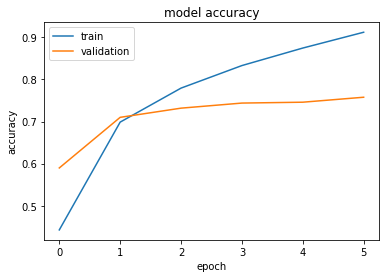

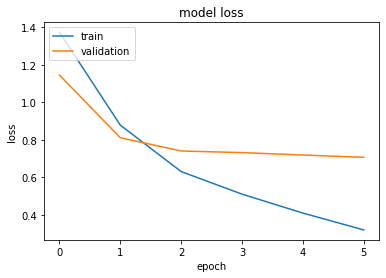

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 75.77%

F1 Score: 75.77


## Testing

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


## Done

In [ ]:
model.save('./exp-1/cnn-w2v')

INFO:tensorflow:Assets written to: ./drive/MyDrive/eecs595-final-project/exp-3/saved-models/cnn-w2v/assets


In [ ]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model('./exp-1/cnn-w2v')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626700   
                                                                 
 conv1d (Conv1D)             (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3,924,433
Trainable params: 297,733
Non-trainable params: 3,626,700
________________________________________